# Project Title
**Predicting Peak-Hour Transport Delays in Nairobi Using Machine Learning
Rush Hour Roulette: Matatu Madness**

# Phase 1: Business Understanding
Objective
Build a supervised machine learning classification model to predict when and where overcrowding will occur at bus and matatu stops in Nairobi during peak hours and rainy seasons. This enables transport operators (SACCOs) to proactively deploy additional vehicles and reduce passenger queues before they form.

# Key Questions

When are bus stops most likely to experience overcrowding? (Peak hours? Rainy days?)

Which routes are most vulnerable to congestion-driven delays?

What combination of factors (weather, time of day, route characteristics) best predicts overcrowding?

Can we flag high-risk periods before queues form, rather than reacting after the fact?

# Business Impact
For Transport Operators (SACCOs):

Revenue Optimization: Deploy buses where/when demand is highest → capture more fares

Fleet Efficiency: Reduce idle vehicles during off-peak times; maximize utilization during peaks

Competitive Advantage: Operators with shorter wait times attract more customers

# For Commuters:

Reduced Wait Times: Fewer people left stranded during rush hour

Improved Reliability: More predictable commute times

Better Experience: Less frustration, safer boarding conditions

# For Urban Planning:

Data-Driven Decisions: Inform infrastructure investments (new routes, bus lanes)

Traffic Management: Coordinate with traffic authorities during predicted congestion spikes

Sustainability: Efficient public transport reduces private vehicle use

# Crisis Management:

Detect weather-triggered congestion early (e.g., heavy rain forecasts)

Prepare contingency plans for major events (strikes, road closures)

# Phase 2: Data Understanding

# Dataset Overview

You're working with three main data sources:

| Data Source                 | Purpose                                | Coverage                                      |
|------------------------------|----------------------------------------|-----------------------------------------------|
| **Weather Data (Open-Meteo API)** | Understand how rain/temperature affects demand | Hourly data for Nairobi, January 2024        |
| **Traffic Data (Simulated)**       | Proxy for congestion levels           | Hourly travel times (35 min avg, 10–120 min range) |
| **GTFS Transit Data (Static Feed)**| Route structure and stop locations    | 136 routes, 4,284 stops, 272 trips           |


# Importing Required Libraries

In [2]:
# Core
import pandas as pd
import numpy as np
import math


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold



# WEATHER DATA(Nairobi):


**SECTION 1:Downloading Nairobi Weather Data** 
1. Rain increases matatu demand (people avoid walking/motorcycles)
2. Rain slows down traffic → fewer buses reach stops per hour

3. Temperature might affect demand (extreme heat/cold changes behavior)

4. Weather is a proven predictor of transport congestion in urban areas

In [3]:

# Import the requests library to make HTTP API calls
import requests

# Define the API endpoint for Open-Meteo's historical weather archive
# Open-Meteo provides free access to historical weather data worldwide
url = "https://archive-api.open-meteo.com/v1/archive"

# Set up the API request parameters
params = {
    "latitude": -1.286389,   # Nairobi's latitude (south of equator, hence negative)
    "longitude": 36.817223,  # Nairobi's longitude (east of prime meridian)
    "start_date": "2024-01-01",  # Beginning of our study period
    "end_date": "2024-01-31",    # End of study period (full month of January)
    "hourly": ["temperature_2m", "precipitation"]  # Request hourly data for:
                                                    # - temperature_2m: temp at 2 meters above ground
                                                    # - precipitation: rainfall in mm per hour
}

# Make the GET request to the API with our parameters
response = requests.get(url, params=params)
# Parse the JSON response into a Python dictionary
weather_json = response.json()


# Convert the nested JSON structure into a pandas DataFrame
# The API returns data in this structure: {"hourly": {"time": [...], "temperature_2m": [...], ...}}

weather = pd.DataFrame({
    "time": weather_json["hourly"]["time"],              # Extract hourly timestamps
    "temperature": weather_json["hourly"]["temperature_2m"],  # Extract temperature readings
    "precipitation": weather_json["hourly"]["precipitation"]   # Extract rainfall amounts
})


# Convert the 'time' column from string format to proper datetime objects
# This allows us to extract hour, day, month, etc. and merge with other time-based data
weather["time"] = pd.to_datetime(weather["time"])

# Display the first 5 rows to verify data loaded correctly
weather.head()

,time,temperature,precipitation
0,2024-01-01 00:00:00,15.4,0.0
1,2024-01-01 01:00:00,16.6,0.0
2,2024-01-01 02:00:00,15.8,0.0
3,2024-01-01 03:00:00,15.4,0.0
4,2024-01-01 04:00:00,16.4,0.0


**SECTION 2: SIMULATED TRAFFIC/TRAVEL TIME DATA**

**WHY WE'RE SIMULATING DATA:**

IDEAL: Real GPS data from matatu fleets showing actual travel times
REALITY: This data is not publicly available or is expensive to access
SOLUTION: Simulate realistic travel times as a PROXY for congestion levels

In production, We would replace this with:

Google Maps Traffic API (travel time estimates)
 
GPS tracking data from matatu SACCOs

Mobile network-based congestion data

Traffic sensor data from Nairobi City Council

In [4]:
# Set random seed for reproducibility
# This ensures we get the same "random" numbers every time we run the code
# Important for scientific reproducibility and debugging
np.random.seed(42)


# Create a DataFrame with simulated travel times
traffic = pd.DataFrame({
    # Create timestamps matching our weather data (same 744 hours)
    "time": pd.date_range("2024-01-01", periods=len(weather), freq="H"),
    # Generate random travel times from a normal (Gaussian) distribution
    # loc=35: Mean travel time is 35 minutes (typical matatu journey in Nairobi)
    # scale=10: Standard deviation of 10 minutes (variability due to traffic)
    # size=len(weather): Generate 744 values (one per hour)
    
    "avg_travel_time_min": np.random.normal(loc=35, scale=10, size=len(weather))
})


# INTERPRETATION OF NORMAL DISTRIBUTION:
# - ~68% of values will be between 25-45 minutes (35 ± 10)
# - ~95% of values will be between 15-55 minutes (35 ± 20)
# - This creates realistic variability: some hours have light traffic, others heavy

# Clip extreme values to realistic bounds
# .clip(10, 120) ensures all values are between 10 and 120 minutes
# WHY?
# - Minimum 10 min: Even with zero traffic, matatus take some time
# - Maximum 120 min: Extreme gridlock scenario (2 hours for routes that normally take 35 min)
# Without clipping, normal distribution could generate negative or unrealistically high values
traffic["avg_travel_time_min"] = traffic["avg_travel_time_min"].clip(10, 120)

# Display first 5 rows to verify
traffic.head()

,time,avg_travel_time_min
0,2024-01-01 00:00:00,39.967142
1,2024-01-01 01:00:00,33.617357
2,2024-01-01 02:00:00,41.476885
3,2024-01-01 03:00:00,50.230299
4,2024-01-01 04:00:00,32.658466


# WHAT TRAVEL TIME REPRESENTS:
 - LOW values (15-25 min): Off-peak hours, light traffic, fast journeys
- MEDIUM values (30-40 min): Normal conditions
- HIGH values (50+ min): Peak hour congestion, slow-moving traffic

HIGH TRAVEL TIME = FEWER BUSES REACH STOPS PER HOUR = OVERCROWDING



# KEY ASSUMPTIONS IN THIS SIMULATION:
 
 1. Travel times follow a normal distribution (reasonable for aggregate data)
 2. All routes have similar average times (simplification - in reality, varies by route)
 3. Congestion is random (in reality, it follows time-of-day patterns)

# LIMITATION: This simulated data won't capture real patterns like:
 - Morning rush (7-9 AM): HIGH travel times
 - Midday lull (11 AM - 3 PM): LOW travel times  
 - Evening rush (5-8 PM): VERY HIGH travel times
 - Weekend patterns: Different from weekdays

TO IMPROVE: Add time-based patterns to the simulation:
travel_time = base + peak_hour_penalty + random_noise

# Phase 3 Data Cleaning 

In this phase, we prepare the dataset by combining multiple data sources, engineering meaningful features, handling data quality issues, and creating our target variable. The main steps are:


**Step 1: Extracting Temporal Features from Weather Data**

**What we're doing:**

Converting text timestamps into Python datetime objects
Creating two new columns: hour and dayofweek

**Why it matters:**

These become critical features for our ML model
Time patterns are the strongest predictors of transport demand
Without these, the model can't learn that 7 AM behaves differently than 2 PM


In [5]:
# Ensure 'time' column is in proper datetime format
# This allows us to extract specific time components (hour, day, etc.)
weather["time"] = pd.to_datetime(weather["time"])

# Extract hour of day (0-23)
# WHY: Rush hour patterns differ by time
# - 7-9 AM: Morning commute into CBD
# - 5-8 PM: Evening commute out of CBD
# - Midnight-5 AM: Very low demand

weather["hour"] = weather["time"].dt.hour

# Extract day of week (0=Monday, 6=Sunday)
# WHY: Weekday vs weekend patterns are dramatically different
# - Mon-Fri: High peak-hour congestion (work commutes)
# - Sat-Sun: Lower demand, different travel patterns

weather["dayofweek"] = weather["time"].dt.dayofweek

**Step 2: Merging Weather and Traffic Data**
    
**What we're doing:**

Performing an inner join on the timestamp column
Each row now contains: weather + traffic for one specific hour

**Why this matters:**

We can now analyze: "When it rained 2.5mm at 6 PM on a Monday, travel times were 55 minutes"
The model learns relationships between weather and congestion

In [6]:
# Ensure traffic data also has proper datetime format
traffic["time"] = pd.to_datetime(traffic["time"])

In [7]:
# Merge weather and traffic on the 'time' column
# This combines weather conditions with congestion levels for each hour
full = weather.merge(traffic, on="time")
full.head()

,time,temperature,precipitation,hour,dayofweek,avg_travel_time_min
0,2024-01-01 00:00:00,15.4,0.0,0,0,39.967142
1,2024-01-01 01:00:00,16.6,0.0,1,0,33.617357
2,2024-01-01 02:00:00,15.8,0.0,2,0,41.476885
3,2024-01-01 03:00:00,15.4,0.0,3,0,50.230299
4,2024-01-01 04:00:00,16.4,0.0,4,0,32.658466


 **Step 3: Loading GTFS Transit Data**
 
Opening a ZIP file without extracting it (efficient)
Reading 4 different CSV files that define Nairobi's matatu system

In [8]:
import zipfile

# Path to the GTFS ZIP file (standard transit data format)

gtfs_zip_path = "GTFS_FEED_2019.zip"

# Extract and load multiple CSV files from the ZIP archive
with zipfile.ZipFile(gtfs_zip_path, 'r') as z:
    stops = pd.read_csv(z.open('stops.txt'))        # Bus stop locations
    routes = pd.read_csv(z.open('routes.txt'))      # Route definitions
    trips = pd.read_csv(z.open('trips.txt'))        # Individual trips
    stop_times = pd.read_csv(z.open('stop_times.txt'))  # Trip schedules

# Verify data loaded correctly
print(stops.head())
print(routes.head())

# Quick sanity check
print(stops.shape)
print(routes.shape)
print(trips.shape)
print(stop_times.shape)


   stop_id           stop_name  stop_lat   stop_lon  location_type  \
0  0001RLW            Railways -1.290884  36.828242            0.0   
1  0002KOJ                Koja -1.281230  36.822596            1.0   
2  0003NGR               Ngara -1.274395  36.823806            1.0   
3  0004ODN               Odeon -1.282769  36.825032            1.0   
4  0005AMB  Kencom/Ambassadeur -1.285963  36.826048            1.0   

  parent_station  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
      route_id agency_id route_short_name                 route_long_name  \
0  10000107D11       UON             107D                     Ruaka-Ruiru   
1  10000114011       UON             114R     Ngara-Rwaka-Ndenderu-Limuru   
2  10000116011       UON              116        Koja-Ngara-Banana-Limuru   
3  10100011A11       UON              11A        Odeon-Aga Khan-Highridge   
4  10200010811       UON              108  UN-New Muthaiga-Gachie-Gichagi   

  

In [9]:
#Confirm What GTFS Tables You Have
import zipfile

with zipfile.ZipFile("GTFS_FEED_2019.zip", "r") as z:
    print(z.namelist())


['agency.txt', 'calendar.txt', 'calendar_dates.txt', 'feed_info.txt', 'frequencies.txt', 'routes.txt', 'shapes.txt', 'stop_times.txt', 'stops.txt', 'trips.txt']


**Step 4: Understanding Route-Stop Relationships**

**What we're doing:**

Performing two consecutive merges to connect three tables
Creating a master table: "Which stops are on which routes?"

**Why we need this:**

Different routes have different characteristics (length, number of stops, distance from CBD)
These characteristics affect overcrowding risk
Example: A 40km route is more vulnerable to traffic delays than a 5km route



In [10]:
# Link stop_times → trips → stops to understand which stops belong to which routes
route_stops = (
    stop_times
    .merge(trips[["trip_id","route_id"]], on="trip_id")  # Add route info to stops
    .merge(stops[["stop_id","stop_name","stop_lat","stop_lon"]], on="stop_id")  # Add location info
    [["route_id","stop_id","stop_name","stop_lat","stop_lon"]]  # Keep only needed columns
    .drop_duplicates()  # Remove duplicate stop-route combinations
)
route_stops.head()


,route_id,stop_id,stop_name,stop_lat,stop_lon
0,10300106011,0110BAA,Banana Terminus,-1.174235,36.758765
1,10000116011,0110BAA,Banana Terminus,-1.174235,36.758765
2,10300106011,0110BNI,Kobil banana,-1.174564,36.758993
3,10300106011,0110UMK,Mkulima supermarket,-1.175079,36.759251
4,10300106011,0110AEA,Shell Banana,-1.175848,36.759530


**Step 5: Engineering Route Features**

**Feature 1: Number of Stops per Route**

**What we're doing:**

Grouping by route, counting how many different stops it serves

**Why it matters:**

More stops = longer journey = more exposure to traffic delays
Routes with 150 stops vs 35 stops behave very differently

In [11]:
# Count unique stops for each route
route_stop_count = (
    route_stops.groupby("route_id")["stop_id"]
    .nunique()  # Count distinct stops (not total occurrences)
    .reset_index(name="num_stops_on_route")
)



**The Haversine Formula:**

**What this calculates:**

Straight-line distance between two GPS coordinates on Earth's curved surface Not exact road distance, but close enough for our purposes

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    lat1, lon1, lat2, lon2 = map(
        math.radians, [lat1, lon1, lat2, lon2]
    )

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = (
        math.sin(dlat/2)**2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    )

    return 2 * R * math.asin(math.sqrt(a))


**Feature 2: Route Length (CORRECTED)**

In [13]:
# STEP 1: Build a trip table with only required columns
trip_stops = (
    stop_times
    .merge(trips[['trip_id','route_id']], on='trip_id')
    .merge(stops[['stop_id','stop_lat','stop_lon']], on='stop_id')
    [['route_id','trip_id','stop_sequence','stop_lat','stop_lon']]
)

# STEP 2: Select ONE representative trip per route
# Pick the longest trip (most stops = most complete path)
trip_lengths = (
    trip_stops.groupby('trip_id')['stop_sequence']
    .count()
    .reset_index(name='n_stops')
)

longest_trips = (
    trip_lengths
    .sort_values('n_stops', ascending=False)  # Sort by trip length
    .merge(trips[['trip_id','route_id']], on='trip_id')
    .drop_duplicates('route_id')  # Keep only the longest trip per route
)

# STEP 3: Merge back and keep stops in CORRECT ORDER
route_paths = (
    longest_trips[['route_id','trip_id']]
    .merge(trip_stops, on=['route_id','trip_id'])
    .sort_values(['route_id','stop_sequence'])  # KEY: Sort by stop_sequence!
)

# STEP 4: Recalculate distance correctly
route_lengths = []

for rid, g in route_paths.groupby('route_id'):
    dist = 0
    g = g.reset_index(drop=True)
    # Now we calculate distance between CONSECUTIVE stops in trip order
    for i in range(len(g)-1):
        dist += haversine(
            g.loc[i,'stop_lat'], g.loc[i,'stop_lon'],
            g.loc[i+1,'stop_lat'], g.loc[i+1,'stop_lon']
        )
    route_lengths.append([rid, dist])

route_length_df = pd.DataFrame(route_lengths, columns=['route_id','route_length_km'])

**What we fixed:**

Used stop_sequence field (1, 2, 3, ...) to order stops correctly
Selected the longest trip per route as a representative path
Calculated distances between consecutive stops only

**Combine Route Features**

In [14]:
route_features = (
    route_stop_count
    .merge(route_length_df, on='route_id', how='inner')
)


In [15]:
#Sanity check results:
route_features['route_length_km'].describe()

#Mean: 12.3 km (realistic for Nairobi matatu routes ✓)
#Min: 1.2 km (short inner-city routes)
#Max: 41.5 km (long routes to satellite towns)

count    136.000000
mean      12.294688
std        8.118641
min        1.208775
25%        6.581010
50%       10.148127
75%       15.862352
max       41.547099
Name: route_length_km, dtype: float64

In [16]:
# PROBLEM: This calculates distance between ALL stop pairs, not just consecutive ones
#What #went wrong:

#We sorted stops alphabetically by stop_id (e.g., "0001", "0002", "0003")
#But the actual route path doesn't follow alphabetical order!
#Example: Route might go: Stop_0005 → Stop_0002 → Stop_0010
#This gave absurd results: 593km, 1019km (longer than Kenya itself!)

#from math import radians, sin, cos, sqrt, atan2

#def haversine(lat1, lon1, lat2, lon2):
   # R = 6371
    #dlat = radians(lat2-lat1)
    #dlon = radians(lon2-lon1)
    #a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    #return 2*R*atan2(sqrt(a), sqrt(1-a))

#route_lengths = []

#for rid, group in route_stops.groupby("route_id"):
    #group = group.sort_values("stop_id")
    #dist = 0
    #for i in range(len(group)-1):
        #dist += haversine(group.iloc[i].stop_lat,
                         # group.iloc[i].stop_lon,
                          #group.iloc[i+1].stop_lat,
                          #group.iloc[i+1].stop_lon)
    #route_lengths.append([rid, dist])
    

#route_length_df = pd.DataFrame(route_lengths, columns=["route_id","route_length_km"])


**Feature 3: Average Distance to CBD**

**What we're doing:**

Measuring how far each route operates from the city center
Taking the average distance across all stops

**Why it matters:**

CBD-bound routes (inbound): Heavy evening congestion (5-8 PM)
Suburb-bound routes (outbound): Heavy morning congestion (7-9 AM)
Distance from CBD is a proxy for whether route faces inbound or outbound traffic 

In [17]:
# Define Nairobi CBD coordinates (city center)
CBD_LAT = -1.286389
CBD_LON = 36.817223

# Calculate average distance of all route stops from CBD
route_cbd = []

for rid, group in route_stops.groupby("route_id"):
    # Calculate distance from CBD to each stop on this route
    d = group.apply(
        lambda r: haversine(CBD_LAT, CBD_LON, r.stop_lat, r.stop_lon),
        axis=1
    )
    # Take the mean distance (average across all stops)
    route_cbd.append([rid, d.mean()])

route_cbd_df = pd.DataFrame(route_cbd, columns=["route_id","avg_distance_to_CBD_km"])

**Merging All Route Features**

In [18]:
# Combine route metadata with engineered features
route_features = (
    routes[['route_id','route_short_name','route_long_name']]
    .merge(route_stop_count, on='route_id')       # Add: number of stops
    .merge(route_length_df, on='route_id')        # Add: route length
    .merge(route_cbd_df, on='route_id')           # Add: CBD distance
)

route_features.head()

,route_id,route_short_name,route_long_name,num_stops_on_route,route_length_km,avg_distance_to_CBD_km
0,10000107D11,107D,Ruaka-Ruiru,68,25.237749,13.490841
1,10000114011,114R,Ngara-Rwaka-Ndenderu-Limuru,149,30.902494,11.649784
2,10000116011,116,Koja-Ngara-Banana-Limuru,94,30.931164,11.254005
3,10100011A11,11A,Odeon-Aga Khan-Highridge,35,4.436434,2.503058
4,10200010811,108,UN-New Muthaiga-Gachie-Gichagi,44,6.012415,7.995713


**Step 6: Creating the Machine Learning Dataset (Cartesian Join)**
    
 This is called a Cartesian product (cross join):

Every hour is paired with every route
Allows model to learn route-specific patterns at different times

**Example rows:**

Row 1: Route 107D at midnight on Jan 1
Row 2: Route 114R at midnight on Jan 1
Row 3: Route 116 at midnight on Jan 1
...
Row 137: Route 107D at 1 AM on Jan 

In [19]:
# Add a dummy column to both datasets (all values = 1)
route_features["key"] = 1
full["key"] = 1

# Merge on the dummy column (creates every possible combination)
ml = full.merge(route_features, on="key").drop("key", axis=1)

**Step 7: Creating the Target Variable**

Our target variable delay_overcrowding identifies problematic hours when bus stops are likely to be overcrowded. We define this using two conditions:


**Travel time threshold (75th percentile):**

Captures the slowest 25% of hours
These are when traffic congestion is severe
Fewer vehicles reach stops → queues build up


**Rain threshold (>0.5 mm):**

Moderate to heavy rainfall
Increases demand (people avoid walking/boda bodas)
Slows traffic (visibility, caution)
Double impact: higher demand + lower supply


**Logical OR (|):**

Overcrowding can happen from traffic OR rain OR both
If either condition is met, label = 1

In [20]:
# IMPORTANT: Create target variable in 'full' BEFORE merging with routes
# This ensures we calculate the threshold on actual hourly data, not duplicated route-hour combinations

# Step 1: Calculate the 75th percentile threshold from hourly travel times
threshold = full["avg_travel_time_min"].quantile(0.75)

# Step 2: Create binary target variable in the 'full' DataFrame
# 1 = Delayed/Overcrowded if EITHER:
#     - Travel time > 75th percentile (top 25% slowest hours), OR
#     - Heavy rain (> 0.5 mm/hour)
# 0 = Normal otherwise
full["delay_overcrowding"] = (
    (full["avg_travel_time_min"] > threshold) |  # Logical OR operator
    (full["precipitation"] > 0.5)
).astype(int)  # Convert True/False to 1/0

# Step 3: Check the class distribution before merging
print("Target variable distribution (before route expansion):")
print(full["delay_overcrowding"].value_counts(normalize=True))


Target variable distribution (before route expansion):
0    0.721774
1    0.278226
Name: delay_overcrowding, dtype: float64


**Interpretation:**

72% Class 0 (normal hours) - 536 out of 744 hours
28% Class 1 (overcrowded hours) - 208 out of 744 hours
Slightly imbalanced but acceptable for modeling

 **Step 8: Creating the Final ML Dataset (Route-Hour Panel**

In [21]:
# Add dummy column to both DataFrames for Cartesian product
route_features["key"] = 1
full["key"] = 1

# Perform cross join: Every hour paired with every route
ml = full.merge(route_features, on="key").drop("key", axis=1)

print(f"Final dataset shape: {ml.shape}")
print(f"Expected rows: {len(full)} hours × {len(route_features)} routes = {len(full) * len(route_features)}")

Final dataset shape: (101184, 13)
Expected rows: 744 hours × 136 routes = 101184


**Preview the merged dataset:**
     

In [22]:
ml.head()

,time,temperature,precipitation,hour,dayofweek,avg_travel_time_min,delay_overcrowding,route_id,route_short_name,route_long_name,num_stops_on_route,route_length_km,avg_distance_to_CBD_km
0,2024-01-01,15.4,0.0,0,0,39.967142,0,10000107D11,107D,Ruaka-Ruiru,68,25.237749,13.490841
1,2024-01-01,15.4,0.0,0,0,39.967142,0,10000114011,114R,Ngara-Rwaka-Ndenderu-Limuru,149,30.902494,11.649784
2,2024-01-01,15.4,0.0,0,0,39.967142,0,10000116011,116,Koja-Ngara-Banana-Limuru,94,30.931164,11.254005
3,2024-01-01,15.4,0.0,0,0,39.967142,0,10100011A11,11A,Odeon-Aga Khan-Highridge,35,4.436434,2.503058
4,2024-01-01,15.4,0.0,0,0,39.967142,0,10200010811,108,UN-New Muthaiga-Gachie-Gichagi,44,6.012415,7.995713


**Step 9: Final Data Quality Checks**

In [23]:
# Check 1: Dataset dimensions
print(f"Dataset shape: {ml.shape}")
print(f"Number of rows: {ml.shape[0]:,}")
print(f"Number of columns: {ml.shape[1]}")

# Check 2: Target variable distribution (should match 'full' percentages)
print("\nTarget variable distribution:")
print(ml["delay_overcrowding"].value_counts(normalize=True))

# Check 3: Missing values
print("\nMissing values per column:")
print(ml.isna().sum())

# Check 4: Data types
print("\nData types:")
print(ml.dtypes)

# Check 5: Summary statistics for numerical features
print("\nNumerical feature summary:")
print(ml[['temperature', 'precipitation', 'avg_travel_time_min', 
          'num_stops_on_route', 'route_length_km', 'avg_distance_to_CBD_km']].describe())


Dataset shape: (101184, 13)
Number of rows: 101,184
Number of columns: 13

Target variable distribution:
0    0.721774
1    0.278226
Name: delay_overcrowding, dtype: float64

Missing values per column:
time                      0
temperature               0
precipitation             0
hour                      0
dayofweek                 0
avg_travel_time_min       0
delay_overcrowding        0
route_id                  0
route_short_name          0
route_long_name           0
num_stops_on_route        0
route_length_km           0
avg_distance_to_CBD_km    0
dtype: int64

Data types:
time                      datetime64[ns]
temperature                      float64
precipitation                    float64
hour                               int64
dayofweek                          int64
avg_travel_time_min              float64
delay_overcrowding                 int32
route_id                          object
route_short_name                  object
route_long_name                   objec

# Phase 4 .Modeling

**Model 1: Logistic Regression (Baseline)**
**Binary Classification – Overcrowding Prediction**

**Why Logistic Regression?**

Logistic Regression is chosen as the baseline model for this project because:

 Handles binary classification (Normal vs Overcrowded)

 Trains and predicts very fast on large datasets (101k+ rows)

 Works well with numerical & temporal features

 Interpretable (important for SACCOs & planners)

 Supports class imbalance handling

 Outputs probabilities, enabling early-warning systems

 Strong baseline to compare against advanced models (Random Forest, XGBoost)

**STEP 1: Define Input Features**
    
In this project, overcrowding is influenced by:

 Time patterns → hour, day of week

 Weather → rain, temperature

 Traffic conditions → average travel time

 Route structure → length, number of stops, distance from CBD
    

In [24]:
# Features used by the model
feature_cols = [
    "temperature",
    "precipitation",
    "hour",
    "dayofweek",
    "avg_travel_time_min",
    "num_stops_on_route",
    "route_length_km",
    "avg_distance_to_CBD_km"
]

# X = what the model sees
X = ml[feature_cols]

# y = what the model predicts
y = ml["delay_overcrowding"]  # 0 = Normal, 1 = Overcrowded


**STEP 2: Split Data into Training & Testing**

**Why split?**

We must evaluate the model on unseen data to ensure it generalizes well.

80% training

20% testing

stratify=y preserves the overcrowding ratio (important due to imbalance)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


**STEP 3: Build Preprocessing Pipeline**
    
**Why use a Pipeline?**

Ensures consistent preprocessing

Prevents data leakage

Makes code clean, reusable, and deployable

Required for proper cross-validation

**What we preprocess:**

Numerical features → StandardScaler
(Logistic Regression is sensitive to feature scale)
    

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


**STEP 4: Create the Full Pipeline**

**This pipeline:**

Scales numerical features

Feeds them into Logistic Regression

**Key parameters:**

class_weight='balanced' → handles imbalance (28% overcrowded)

max_iter=2000 → ensures convergence

solver='saga' → supports L1 & L2 regularization

In [27]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=2000,
        class_weight='balanced',
        random_state=42
    ))
])


**STEP 5: Hyperparameter Tuning**
**Why tune hyperparameters?**

We don’t know the best balance between:

Underfitting (too simple)

Overfitting (too complex)

**Parameters Tested**

C → regularization strength

Small C → stronger regularization

Large C → more flexible model

**Penalty**

l1 → feature selection

l2 → smooth shrinkage

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'clf__C': [0.01, 0.1, 1, 5],
    'clf__penalty': ['l1', 'l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='f1',     # Focus on detecting overcrowding
    cv=cv,
    n_jobs=-1,
    verbose=2
)


**STEP 6: Train the Model**

In [31]:
grid.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 5],
                         'clf__penalty': ['l1', 'l2']},
             scoring='f1', verbose=2)

**STEP 7: Get Best Model & Predict**

In [33]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


**STEP 8: Evaluate Model Performance**

In [34]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("=" * 60)
print("BEST LOGISTIC REGRESSION MODEL RESULTS")
print("=" * 60)
print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV F1 Score: {grid.best_score_:.4f}")

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred))


BEST LOGISTIC REGRESSION MODEL RESULTS
Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Best CV F1 Score: 0.9581

Test Accuracy: 0.9746
Test F1 Score: 0.9560

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     14607
           1       0.92      0.99      0.96      5630

    accuracy                           0.97     20237
   macro avg       0.96      0.98      0.97     20237
weighted avg       0.98      0.97      0.97     20237



**TEP 9: Visualize Confusion Matrix**

This shows where the model makes mistakes:

True Positives → correctly predicted overcrowding

False Negatives → dangerous (missed congestion!)

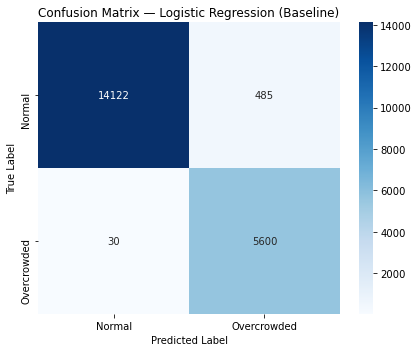

INTERPRETATION
Total test samples: 20237
Correct predictions: 19722
Incorrect predictions: 515

Overcrowding detection:
  Correctly detected overcrowding hours: 5600
  Missed overcrowding hours (false negatives): 30


In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Overcrowded'],
            yticklabels=['Normal', 'Overcrowded'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Logistic Regression (Baseline)")
plt.tight_layout()
plt.show()

#STEP 10: Interpretation of Results
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)

total = len(y_test)
correct = (y_test == y_pred).sum()
incorrect = total - correct

print(f"Total test samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")

# Overcrowding detection performance
tp = ((y_test == 1) & (y_pred == 1)).sum()
fn = ((y_test == 1) & (y_pred == 0)).sum()

print("\nOvercrowding detection:")
print(f"  Correctly detected overcrowding hours: {tp}")
print(f"  Missed overcrowding hours (false negatives): {fn}")

